In [1]:
%load_ext autoreload
%autoreload 2

import lzma
import dill
import json
import pandas as pd
import shap
from tqdm.auto import tqdm
import numpy as np
import tensorflow as tf
from pathlib import Path

import scienceplots

import matplotlib.pyplot as plt
import matplotlib as mpl

from matal import load_model, load_data, auto_log, DATA_DIR, MODEL_DIR, cache_return

In [24]:
vmodel = load_model('vmodels_final')
vmodel

{'VLTransmittance': MOVotingRegressor(estimators=[('14_VLTransmittance_1_VJ3HSBM3',
                                MLPNetwork(input_norm=True,
                                           name='14_VLTransmittance_1_VJ3HSBM3',
                                           output_scale=100)),
                               ('14_VLTransmittance_2_PCSTZBJN',
                                MLPNetwork(input_norm=True,
                                           name='14_VLTransmittance_2_PCSTZBJN',
                                           output_scale=100)),
                               ('14_VLTransmittance_3_VUUFLQTS',
                                MLPNetwork(input_norm=True,
                                           name='14_VLTransmittance_3_VUUFLQTS',
                                           output_scale=100)),
                               ('14_VLTransmittance_4_VJ3HSBM3',
                                MLPNetwork(input_norm=True,
                                           name='

In [12]:
X_COLS = ['MMT', 'CNF', 'GEL', 'GLY']
Y_COLS = ['VLTransmittance', 'UVTransmittance', 'IRTransmittance',
          'AshAreaRatio', 
          'Stress', 'Strain', 'Modulus']

round_df = load_data('14.train_data__da0.table.csv')
X_train, y_train = round_df[X_COLS], round_df[Y_COLS]

In [13]:
explainer_lut = {y: shap.explainers.Exact(vmodel[y].predict, X_train) for y in tqdm(Y_COLS)}
shap_values_lut = {y: explainer_lut[y](X_train) for y in tqdm(Y_COLS)}

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(0.5, -1.777777777777784, 'SHAP Value on $T_{vis}$')

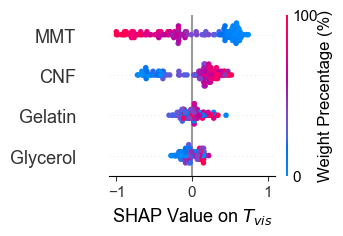

In [23]:
import copy
import shap

src_names = ['MMT', 'CNF', 'Gelatin', 'Glycerol']

shap.plots._labels.labels['FEATURE_VALUE_LOW'] = '0'
shap.plots._labels.labels['FEATURE_VALUE_HIGH'] = '100'

mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['mathtext.default'] = 'it'

x_jitter = 0
y_jitter = 0

d = []
cmap  =  shap.plots.colors.red_blue

y = 'UVTransmittance'
y_label = '$T_{vis}$'


v = copy.deepcopy(shap_values_lut[y])
vmax = np.abs(v.values).max()
vmin = - np.abs(v.values).max()
v.values = (v.values - vmin) / (vmax - vmin) * 2.0 - 1.0
d.append(pd.DataFrame(v.values, columns=[f'{y}_{s}' for s  in src_names]))
v.base_values = (v.base_values - vmin) / (vmax - vmin) * 2.0 - 1.0

shap.summary_plot(v, X_train, feature_names = src_names, plot_size=(3.5, 2.5), sort=False, show=False, 
               color_bar_label='Weight Precentage (%)',  cmap=cmap)
fig, ax = plt.gcf(), plt.gca()
ax.set_ylim(-0.5, 3.5)
ax.set_xlim(-1.1, 1.1)
ax.set_xlabel(f'SHAP Value on {y_label}')
